# U-Net on UWMGI

In [14]:
import numpy as np
import pandas as pd
import random
from glob import glob
import os, shutil
import gc
from PIL import Image
from typing import Dict, List, Tuple, Any, Optional

import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, StratifiedKFold

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

import segmentation_models_pytorch as smp
import albumentations as A
import wandb

from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# Config

In [2]:
class CONFIG:
    seed = 42
    exp_name      = 'unet-base'
    comment       = 'unet-with-efficientnet-b0-base-224x224'
    model_name    = 'Unet'
    base_model    = 'efficientnet-b0'
    train_bs      = 64
    valid_bs      = 2 * train_bs
    image_size    = [224, 224]
    epochs        = 10
    scheduler     = 'CosineAnnealingLR'
    min_lr        = 1e-6
    T_max         = int(30000/train_bs*epochs)+50
    T_0           = 25
    warmup_epochs = 0
    wd            = 1e-6
    n_accumulate  = max(1, 32//train_bs)
    n_fold        = 5
    num_classes   = 3
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Reproducibility

In [3]:
def set_seed(seed: int = 42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    print('--- SEEDED ---')

set_seed(CONFIG.seed)

--- SEEDED ---


# Untility

## RLE

In [4]:
def rle_decode(mask_rle, shape):
    '''
    Extracted from: https://www.kaggle.com/code/paulorzp/run-length-encode-and-decode/script
    
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)


def rle_encode(img):
    '''
    Extracted from: https://www.kaggle.com/code/paulorzp/run-length-encode-and-decode/script
    
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

## Data

In [5]:
df = pd.read_csv('../data/uw-madison-gi-tract-image-segmentation/train.csv')
df.head(10)

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN
5,case123_day20_slice_0002,stomach,NaN
6,case123_day20_slice_0003,large_bowel,NaN
7,case123_day20_slice_0003,small_bowel,NaN
8,case123_day20_slice_0003,stomach,NaN
9,case123_day20_slice_0004,large_bowel,NaN


In [6]:
df['segmentation'].fillna('', inplace=True)
# df['segmentation'] = df['segmentation'].apply(lambda x: x.split(' '))
df.head(10)

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,
1,case123_day20_slice_0001,small_bowel,
2,case123_day20_slice_0001,stomach,
3,case123_day20_slice_0002,large_bowel,
4,case123_day20_slice_0002,small_bowel,
5,case123_day20_slice_0002,stomach,
6,case123_day20_slice_0003,large_bowel,
7,case123_day20_slice_0003,small_bowel,
8,case123_day20_slice_0003,stomach,
9,case123_day20_slice_0004,large_bowel,


In [7]:
df['path'] = ''

In [21]:
def get_path(x):
    case = x.split('_')[0]
    day = x.split('_')[1]
    _slice = x.split('_')[2] + '_' + x.split('_')[3]
    paths = glob(f'../data/uw-madison-gi-tract-image-segmentation/train/{case}/{case}_{day}/scans/{_slice}*')
    path = paths[0]
    image_sizes = path.split('/')[-1].split('_')[2:4]
    image_sizes = [int(x) for x in image_sizes]
    return path, image_sizes

In [22]:
get_path('case123_day20_slice_0001')

('../data/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png',
 [266, 266])

In [26]:
def process_df(df: pd.DataFrame):
    df['case'] = df['id'].apply(lambda x: x.split('_')[0])
    df['day'] = df['id'].apply(lambda x: x.split('_')[1])
    df['slice'] = df['id'].apply(lambda x: x.split('_')[2] + '_' + x.split('_')[3])
    df['path'] = df['id'].apply(lambda x: get_path(x)[0])
    df['height'] = df['id'].apply(lambda x: get_path(x)[1][0])
    df['width'] = df['id'].apply(lambda x: get_path(x)[1][1])
    return df

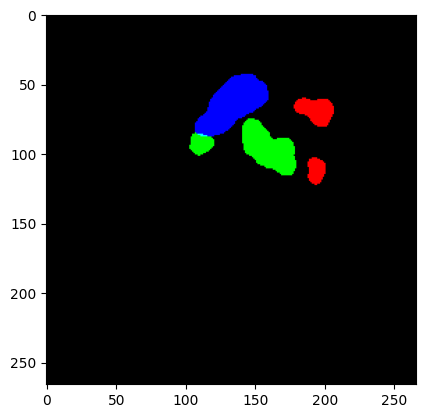

In [27]:
mask = np.zeros((266, 266, 3))
dfs = df[df['id'] == 'case123_day20_slice_0090']

for ix, classes in enumerate(['large_bowel', 'small_bowel', 'stomach']):
    rle = dfs[dfs['class'] == classes]['segmentation'].squeeze()
    mask[..., ix] = rle_decode(rle, shape=(266, 266))

plt.imshow(mask);

# Dataset

In [28]:
df = process_df(df)
df

,id,class,segmentation,path,case,day,slice,height,width
0,case123_day20_slice_0001,large_bowel,,../data/uw-madison-gi-tract-image-segmentation...,case123,day20,slice_0001,266,266
1,case123_day20_slice_0001,small_bowel,,../data/uw-madison-gi-tract-image-segmentation...,case123,day20,slice_0001,266,266
2,case123_day20_slice_0001,stomach,,../data/uw-madison-gi-tract-image-segmentation...,case123,day20,slice_0001,266,266
3,case123_day20_slice_0002,large_bowel,,../data/uw-madison-gi-tract-image-segmentation...,case123,day20,slice_0002,266,266
4,case123_day20_slice_0002,small_bowel,,../data/uw-madison-gi-tract-image-segmentation...,case123,day20,slice_0002,266,266
...,...,...,...,...,...,...,...,...,...
115483,case30_day0_slice_0143,small_bowel,,../data/uw-madison-gi-tract-image-segmentation...,case30,day0,slice_0143,266,266
115484,case30_day0_slice_0143,stomach,,../data/uw-madison-gi-tract-image-segmentation...,case30,day0,slice_0143,266,266
115485,case30_day0_slice_0144,large_bowel,,../data/uw-madison-gi-tract-image-segmentation...,case30,day0,slice_0144,266,266
115486,case30_day0_slice_0144,small_bowel,,../data/uw-madison-gi-tract-image-segmentation...,case30,day0,slice_0144,266,266


In [30]:
ids = df['id'].unique()

In [32]:
len(ids)

38496

In [36]:
_id = ids[1]

In [37]:
_id

'case123_day20_slice_0002'

In [40]:
df[df['id'] == _id].reset_index(drop=True)

,id,class,segmentation,path,case,day,slice,height,width
0,case123_day20_slice_0002,large_bowel,,../data/uw-madison-gi-tract-image-segmentation...,case123,day20,slice_0002,266,266
1,case123_day20_slice_0002,small_bowel,,../data/uw-madison-gi-tract-image-segmentation...,case123,day20,slice_0002,266,266
2,case123_day20_slice_0002,stomach,,../data/uw-madison-gi-tract-image-segmentation...,case123,day20,slice_0002,266,266


In [43]:
df[df['id'] == _id].reset_index(drop=True).iloc[0]['path'].split('/')

['..',
 'data',
 'uw-madison-gi-tract-image-segmentation',
 'train',
 'case123',
 'case123_day20',
 'scans',
 'slice_0002_266_266_1.50_1.50.png']

In [44]:
BASE_PATH = '../data/processed-v1/train/'

In [ ]:
for _id in tqdm(ids):
    dfs = df[df['id'] == _id].reset_index(drop=True)
    height = dfs.iloc[0]['height']
    width = dfs.iloc[0]['width']
    case = dfs.iloc[0]['case']
    day = dfs.iloc[0]['day']
    
    mask = np.zeros(shape=(height, width, 3))
    
    for ix, classes in enumerate(['large_bowel', 'small_bowel', 'stomach']):
        rle = dfs[dfs['class'] == classes]['segmentation'].squeeze()
        mask[..., ix] = rle_decode(mask_rle=rle, shape=[height, width])
        
    
    plt.imsave(f'../data/processed-v1/train/{}', mask)
        

In [46]:
df.to_csv('../data/processed-v1/train.csv')